## Configuration for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !pip install JSAnimation==0.1
    !pip install pyglet==1.3.2
    
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 01. REINFORCE

## import module

In [2]:
import os
from typing import Tuple, List

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

from IPython.display import clear_output

## Network

In [3]:
class Network(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        log_std_min: float = -20,
        log_std_max: float = 2,
    ):
        """Initialization."""
        super(Network, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.hidden_layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
        )
        
        self.mu = nn.Sequential(
            nn.Linear(128, out_dim),
            nn.Tanh(),
        )
        
        self.std = nn.Sequential(
            nn.Linear(128, out_dim),
            nn.Tanh(),
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        hidden_outputs = self.hidden_layer(state)
        mu = self.mu(hidden_outputs)
        log_std = self.std(hidden_outputs)
        log_std = self.log_std_min + 0.5 * (self.log_std_max - self.log_std_min) * (
            log_std + 1
        )
        std = torch.exp(log_std)

        dist = Normal(mu, std)
        
        return dist

## Agent

In [4]:
class REINFORCEAgent:
    """REINFORCE Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        gamma (float): discount factor
    """
    def __init__(
        self,
        env: gym.Env,
        gamma: float = 0.99
    ):
        """Initialize.

        Args:
            env(gym.Env): openAI Gym environment
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.gamma = gamma

        self.log_prob_sequence = list()
        self.reward_sequence = list()

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: reinforce
        self.reinforce = Network(obs_dim, action_dim).to(self.device)

        # optimizer
        self.optimizer = optim.Adam(self.reinforce.parameters(), lr=3e-4)

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        
        dist = self.reinforce(state)
        selected_action = dist.sample()
        
        self.log_prob_sequence.append(dist.log_prob(selected_action))
                
        return selected_action.cpu().numpy()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)
    
        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        loss = 0
        next_return_value = 0
        return_sequence = list()
        
        # return G_t = R_(t+1) + gamma * G_(t+1)
        for reward_value in reversed(self.reward_sequence):
            next_return_value = return_value = reward_value + self.gamma * next_return_value
            return_sequence.append(return_value)
        
        return_sequence_tensor = torch.Tensor(list(reversed(return_sequence))).to(self.device)
        
        # standardize returns for better stability
        return_sequence = (
            return_sequence_tensor - return_sequence_tensor.mean()
        ) / (return_sequence_tensor.std() + 1e-7)
        
        # calculate loss
        for log_prob, return_value in zip(self.log_prob_sequence, return_sequence):
            loss += -return_value * log_prob
        loss /= len(return_sequence)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # clear
        self.log_prob_sequence.clear()
        self.reward_sequence.clear()
        
        return loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        losses = []
        scores = []
        score = 0
        
        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            
            self.reward_sequence.append(reward)

            state = next_state
            score += reward

            # if episode ends
            if done:
                # update model using return
                loss = self.update_model()
                losses.append(loss)
            
                state = env.reset()
                scores.append(score)
                score = 0

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses)
                
        self.env.close()
        
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(122)
        plt.title('loss')
        plt.plot(losses)
        plt.show()

## Environment

## Pendulum-v0
<img src="https://media.giphy.com/media/gHJavzDcIQ0Z8WCk97/giphy.gif" width="200" height="140"/>

Reference: [OpenAI gym Pendulum-v0](https://github.com/openai/gym/wiki/Pendulum-v0)

### Observation

Type: Box(3)

Num | Observation  | Min | Max  
----|--------------|-----|----   
0   | cos(theta)   | -1.0| 1.0
1   | sin(theta)   | -1.0| 1.0
2   | theta dot    | -8.0| 8.0


### Actions

Type: Box(1)

Num | Action  | Min | Max  
----|--------------|-----|----   
0   | Joint effort | -2.0| 2.0

### Reward

The precise equation for reward:

    -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2)

Theta is normalized between -pi and pi. Therefore, the lowest cost is `-(pi^2 + 0.1*8^2 + 0.001*2^2) = -16.2736044`, and the highest cost is `0`. In essence, the goal is to remain at zero angle (vertical), with the least rotational velocity, and the least effort. 

In [5]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

In [6]:
# environment
env_id = "Pendulum-v0"
env = gym.make(env_id)
env = ActionNormalizer(env)

## Set random seed

In [7]:
seed = 777

np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

[777]

## Initialize

In [8]:
# parameters
num_frames = 100000

agent = REINFORCEAgent(env)

cuda


## Train

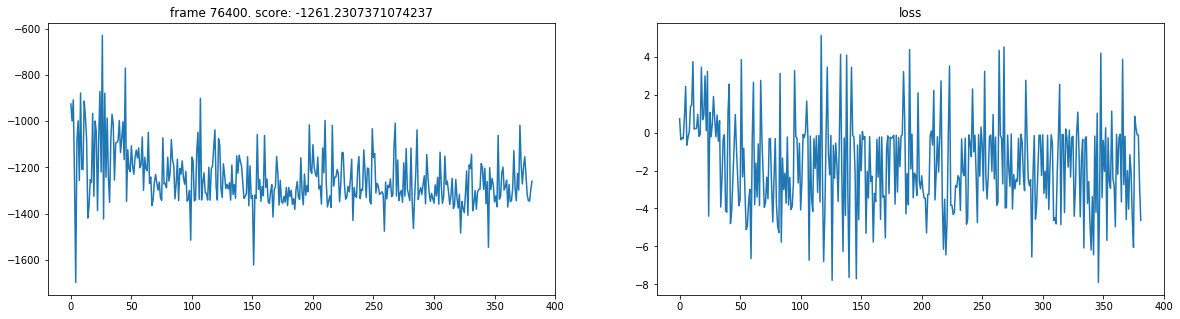

In [ ]:
agent.train(num_frames)

## Test

In [ ]:
frames = agent.test()

## Render


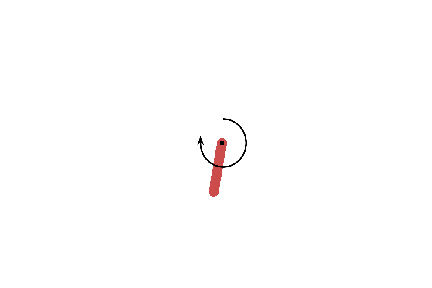
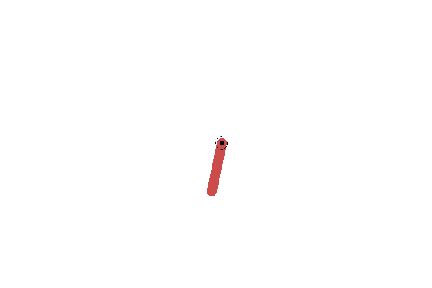
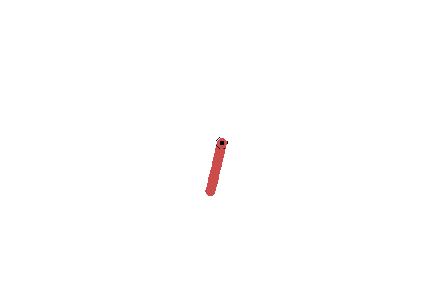
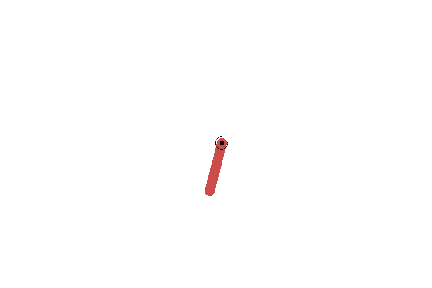
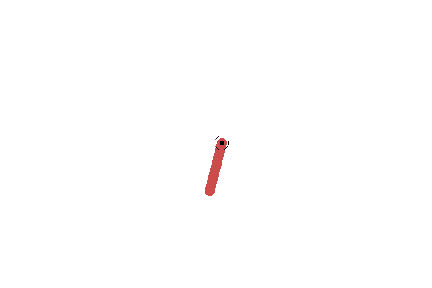
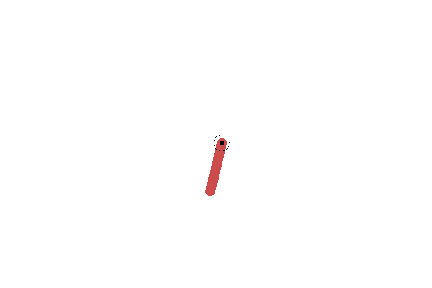
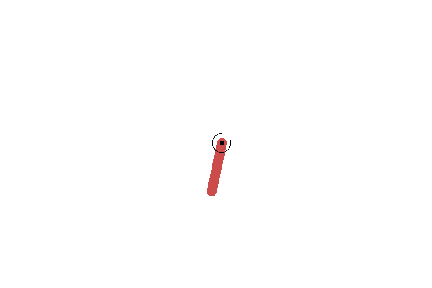
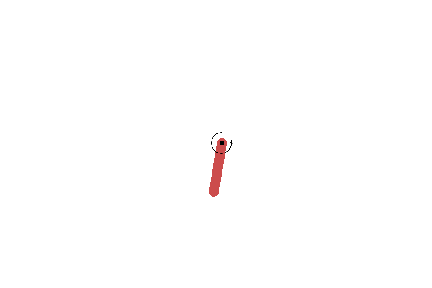
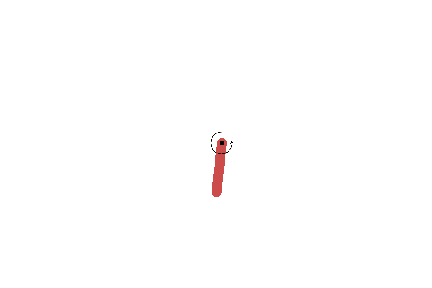
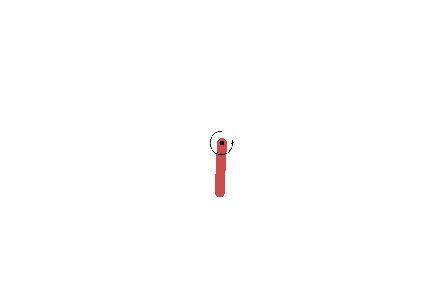
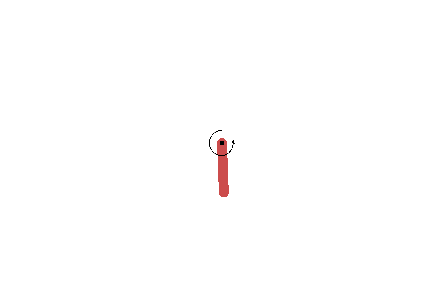
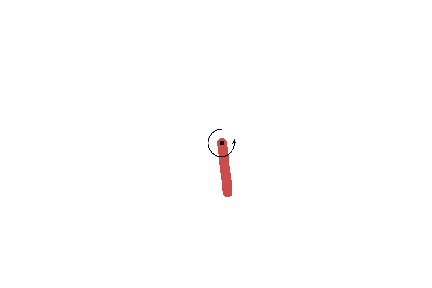
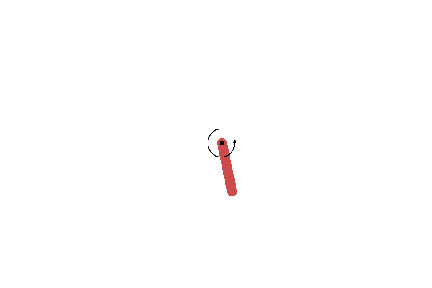
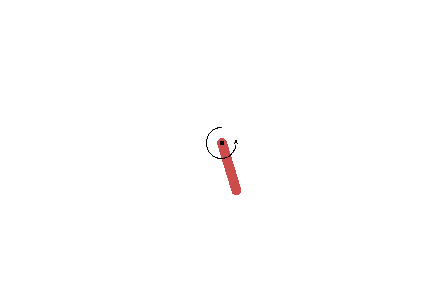
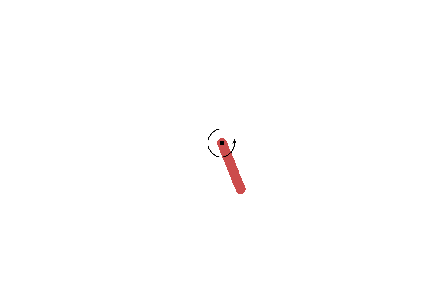
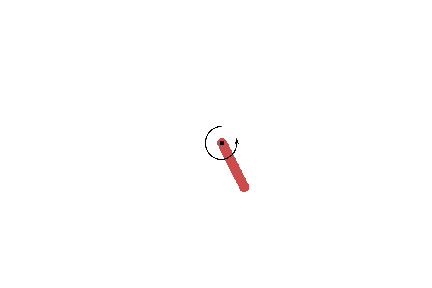
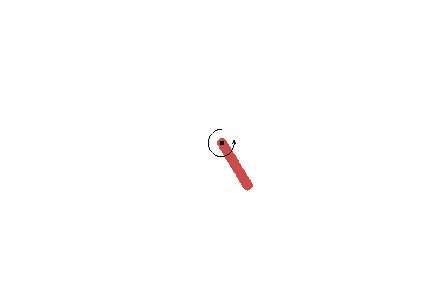
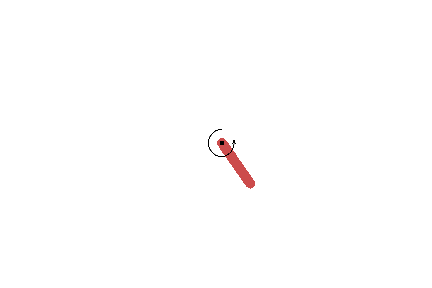
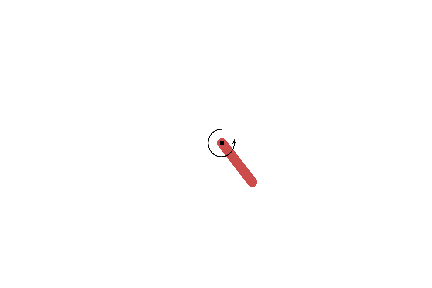
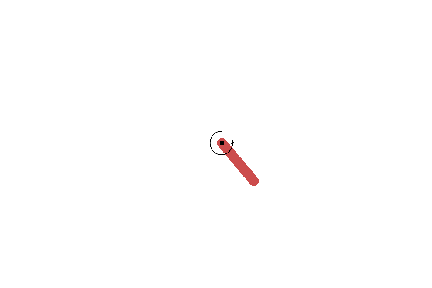
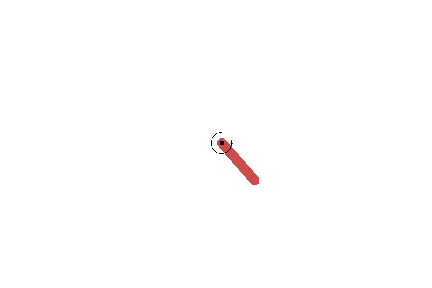
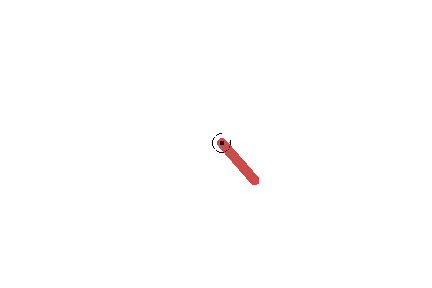
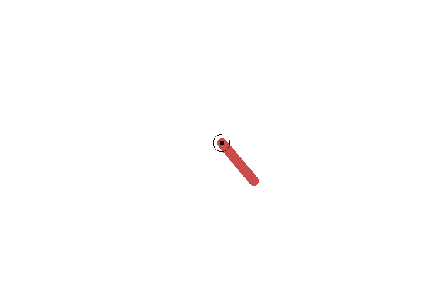
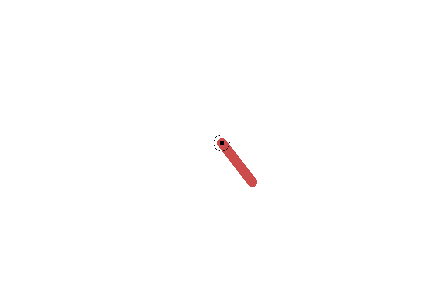
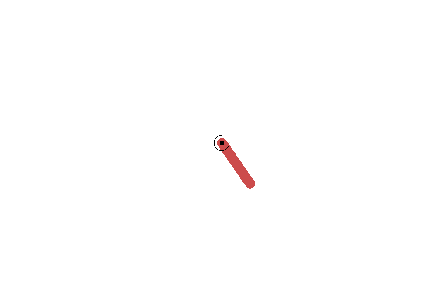
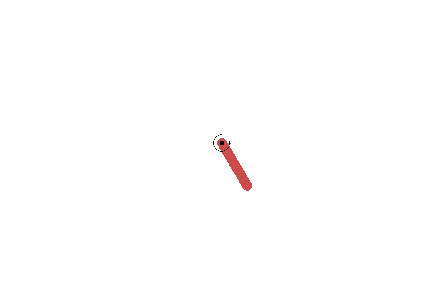
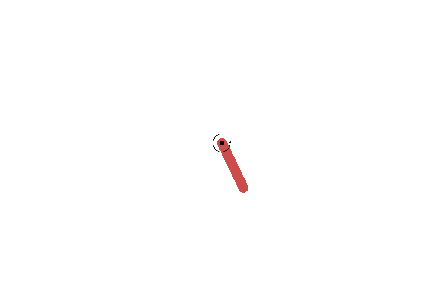
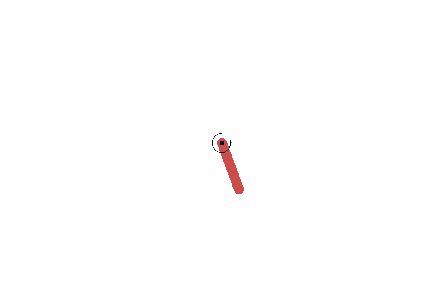
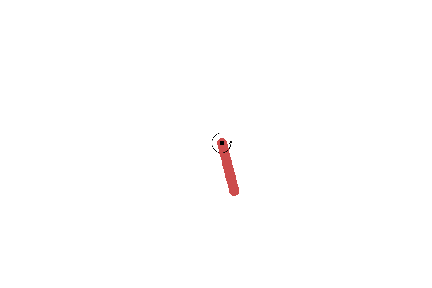
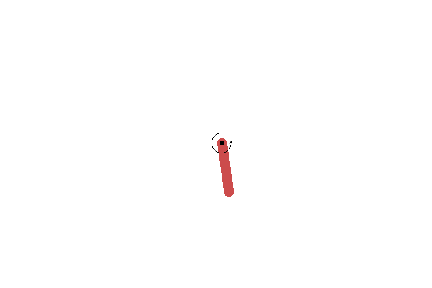
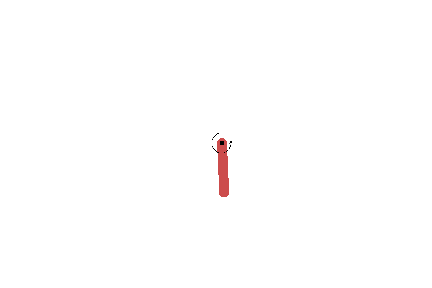
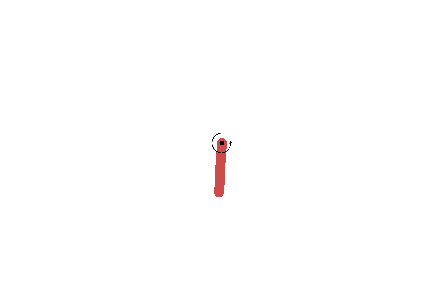
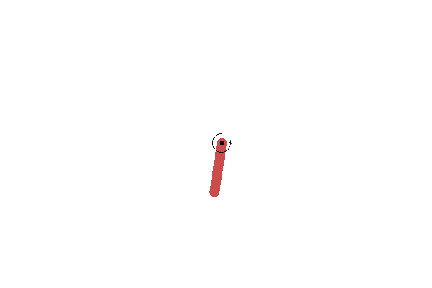
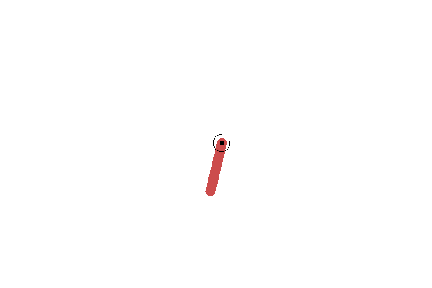
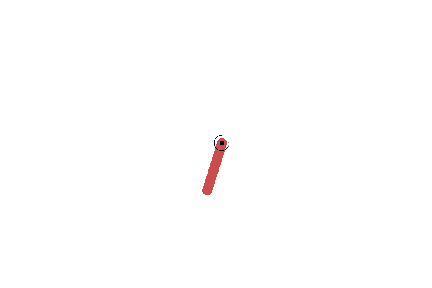
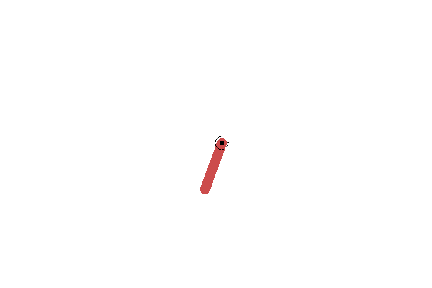
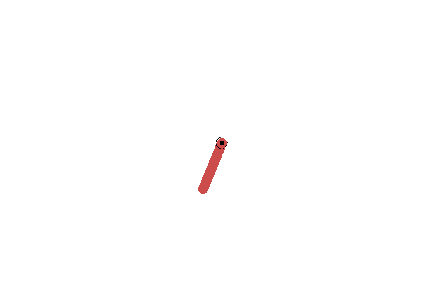
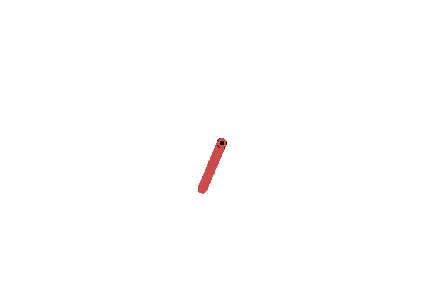
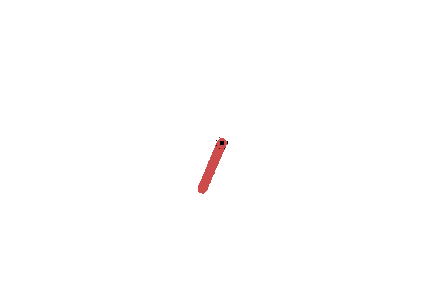
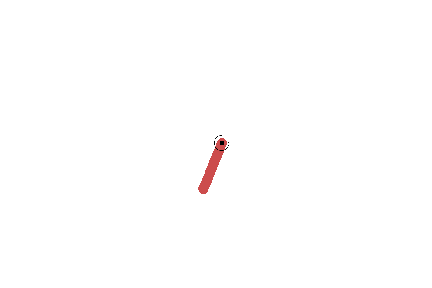
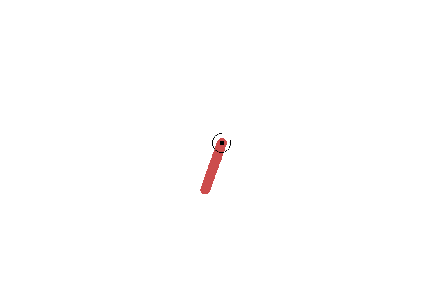
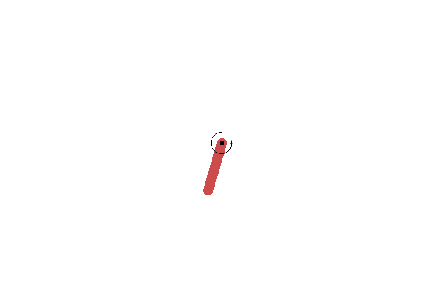
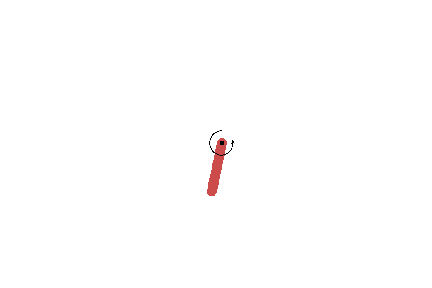
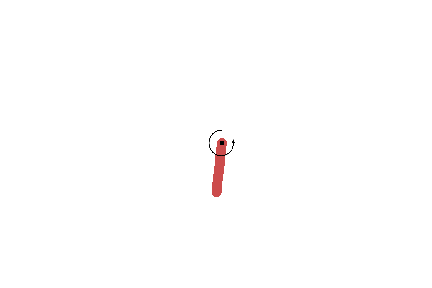
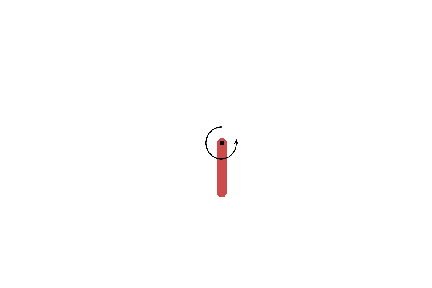
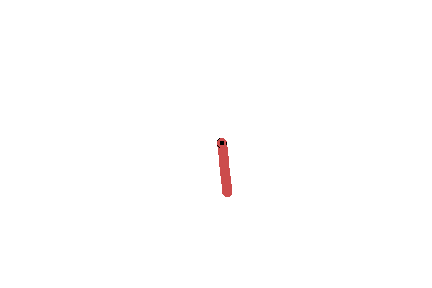
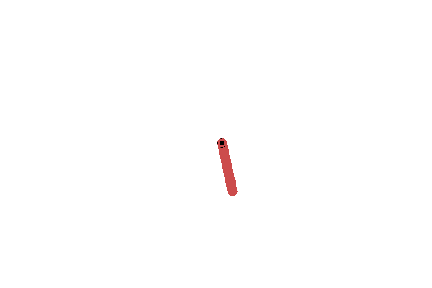
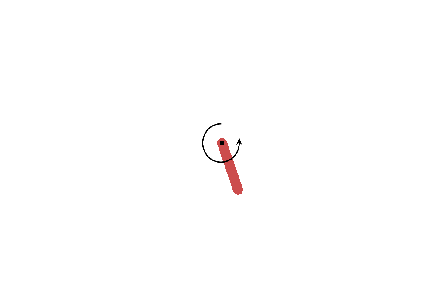
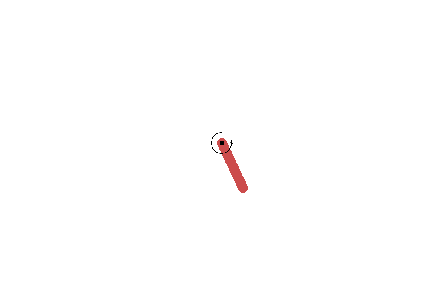
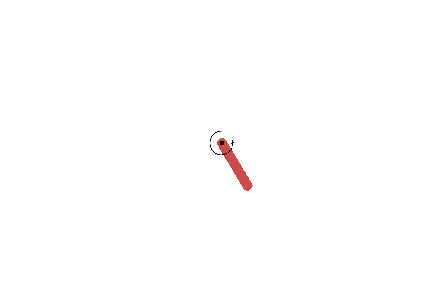
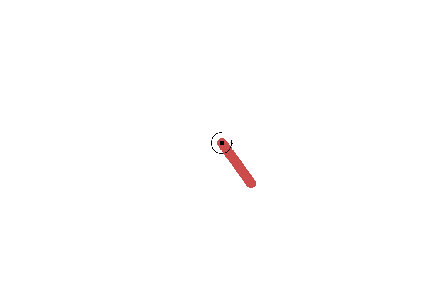
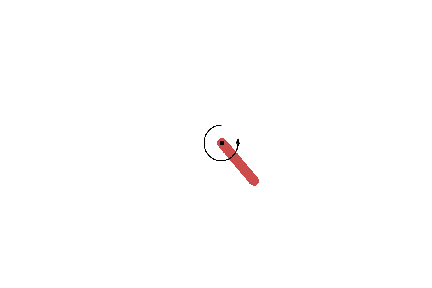
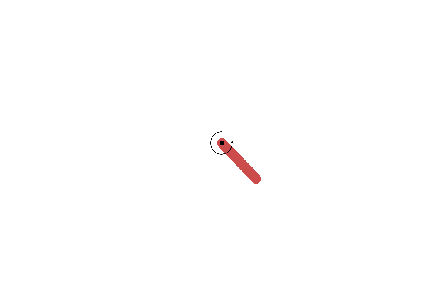
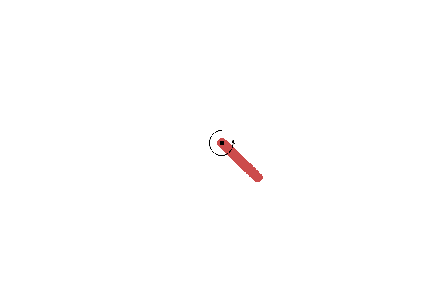
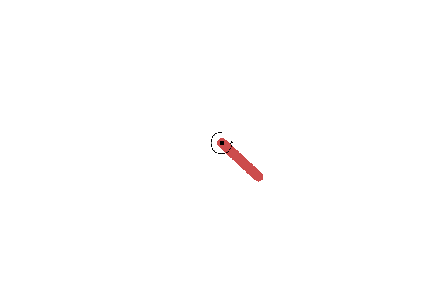
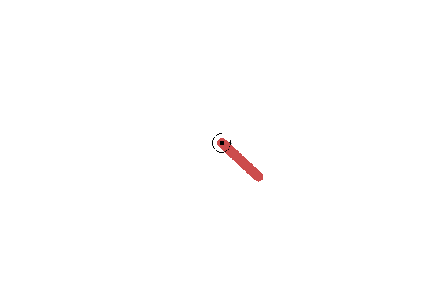
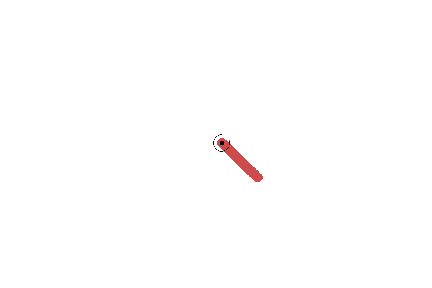
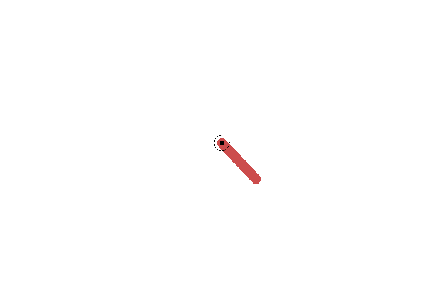
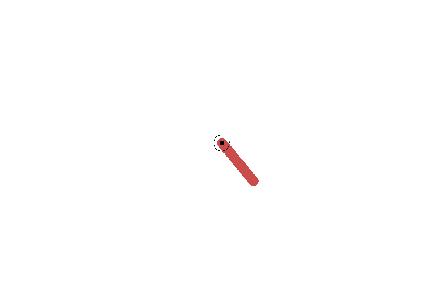
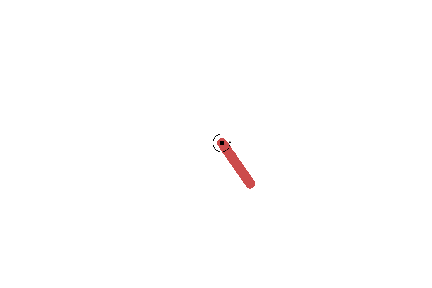
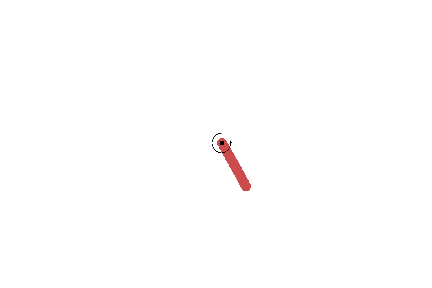
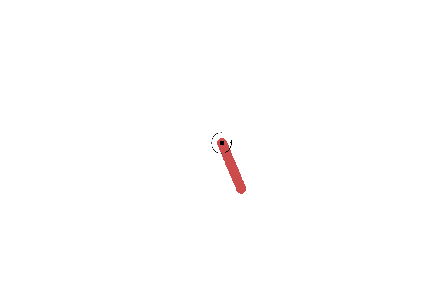
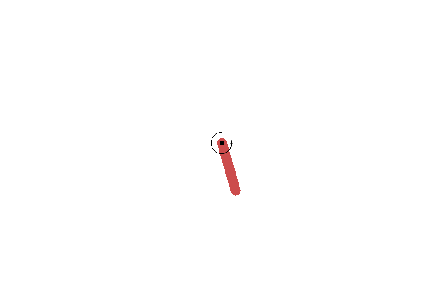
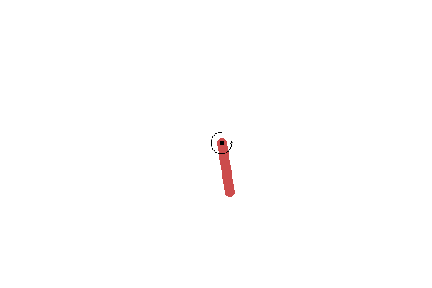
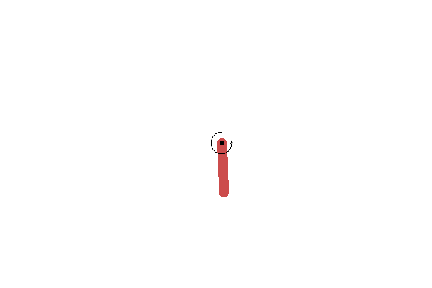
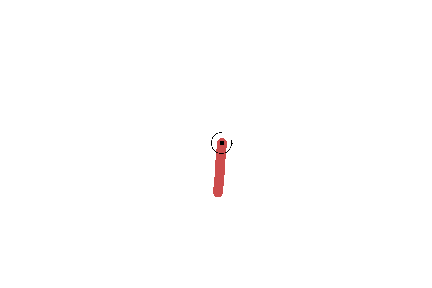
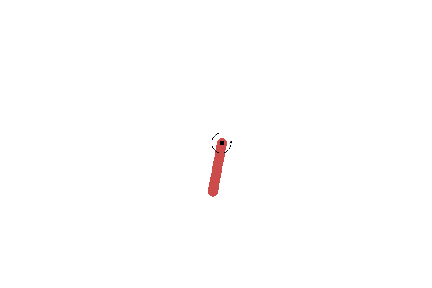
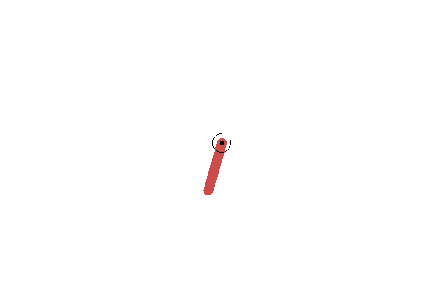
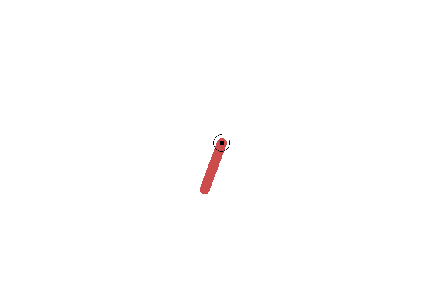
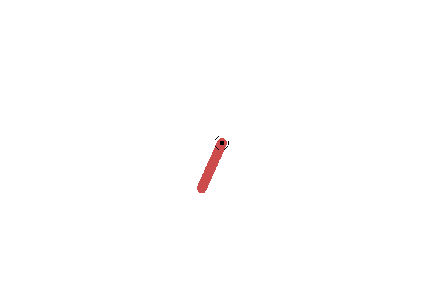
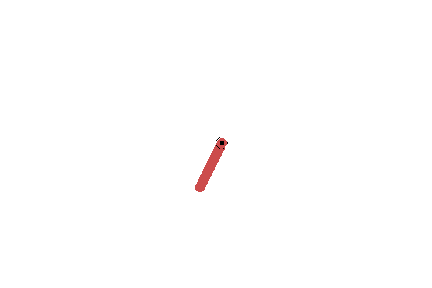
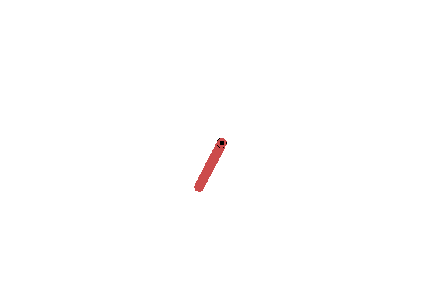
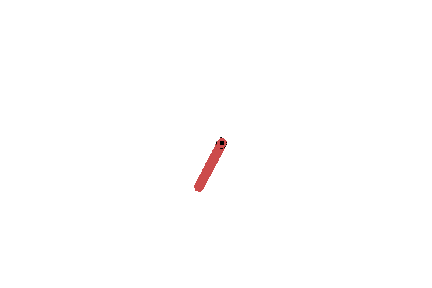
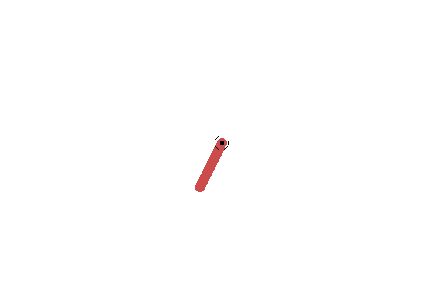
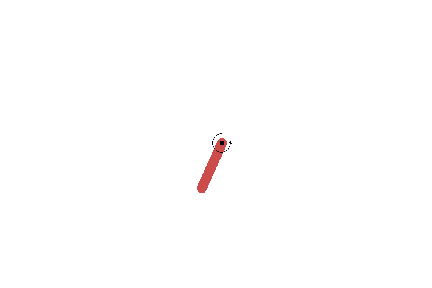
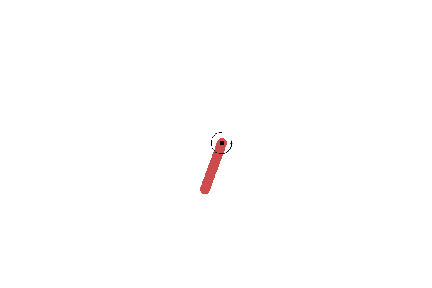
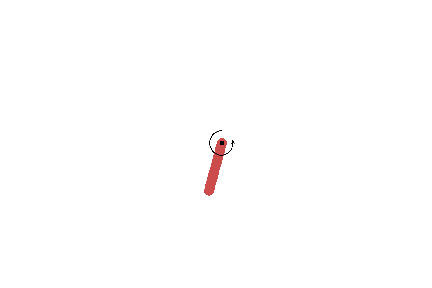
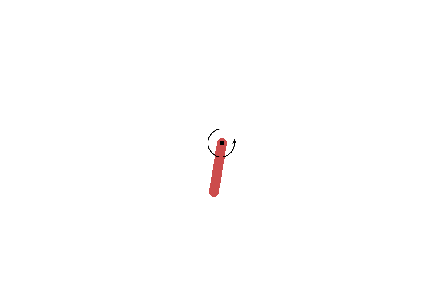
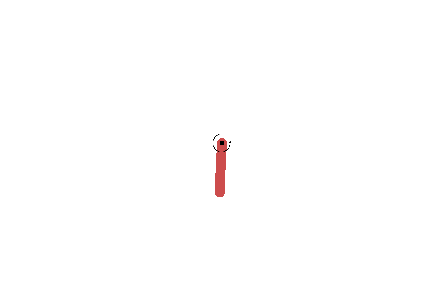
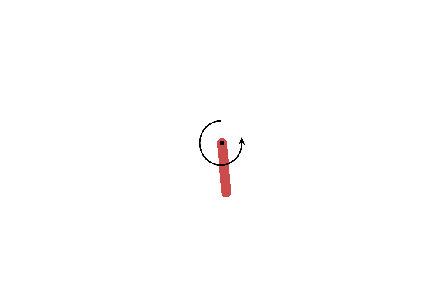
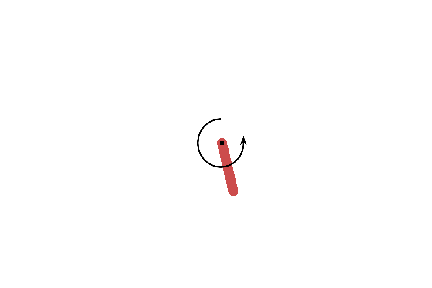
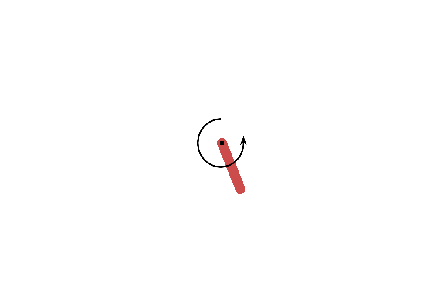
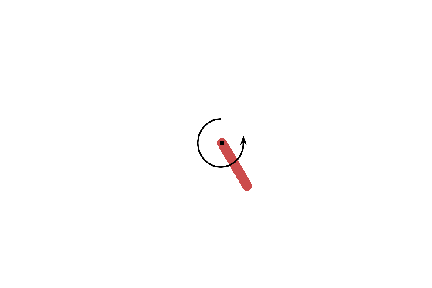
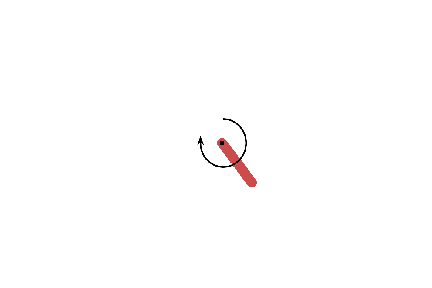
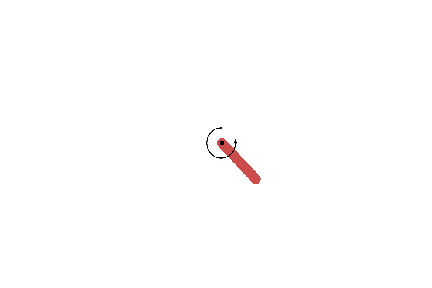
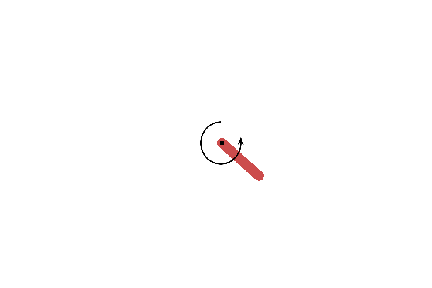
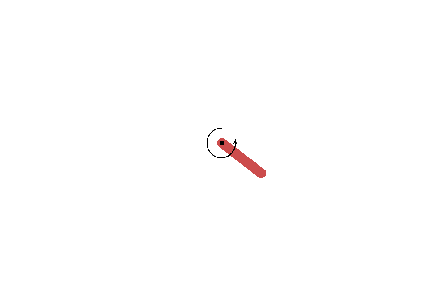
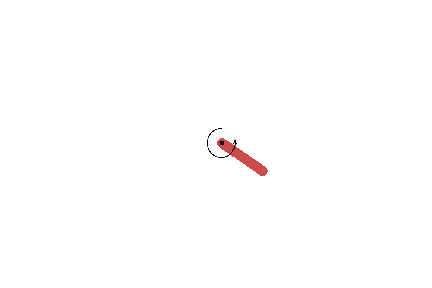
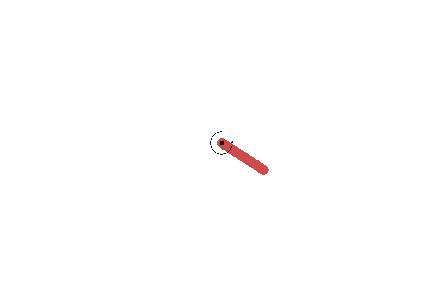
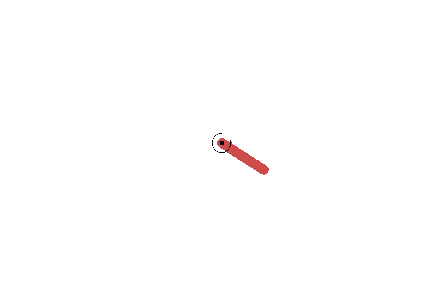
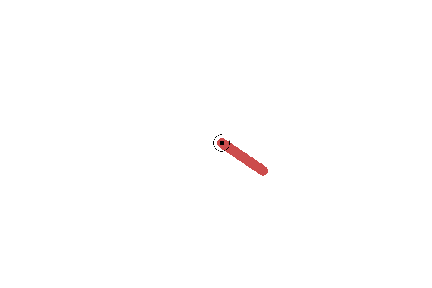
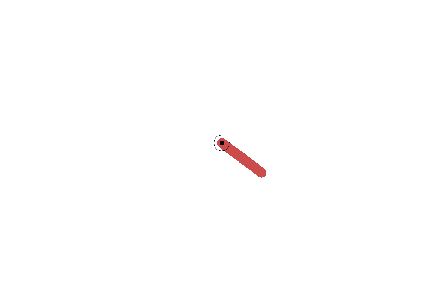
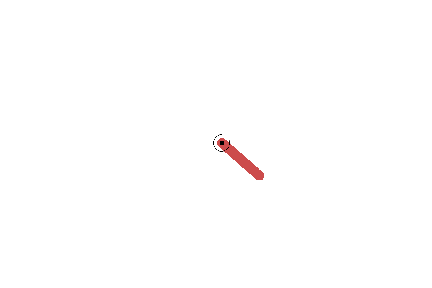
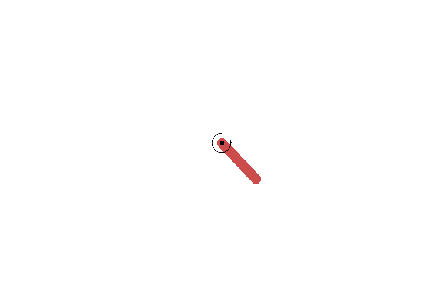
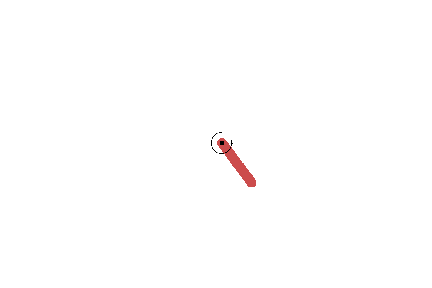
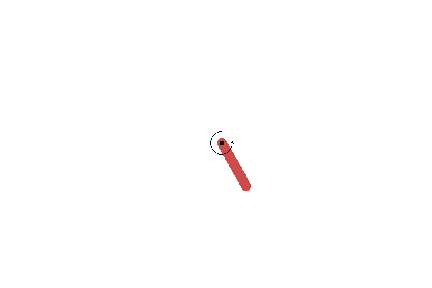
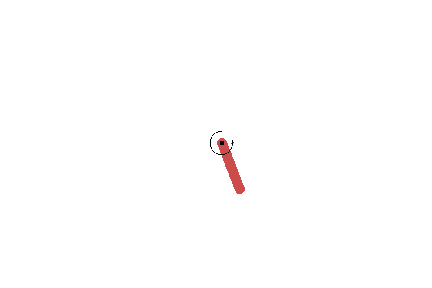
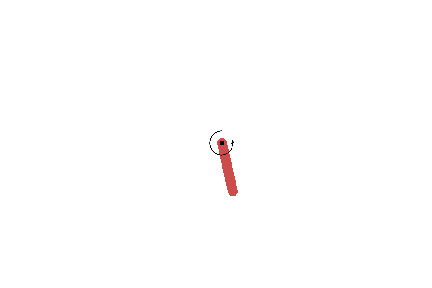
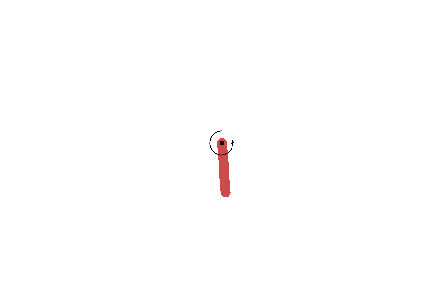
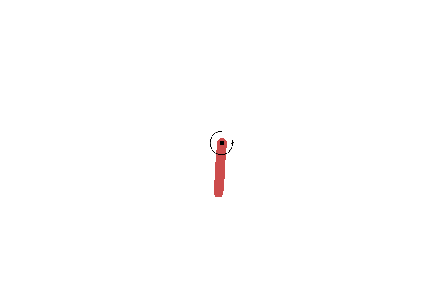
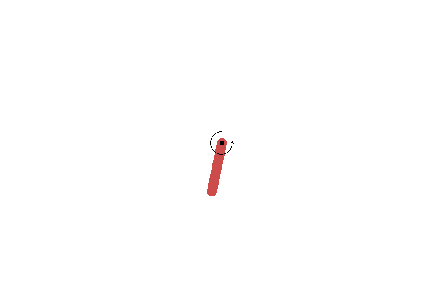
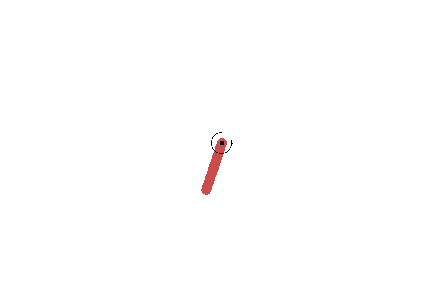
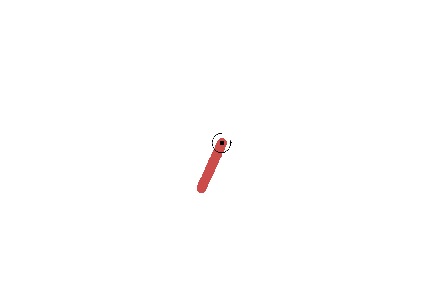
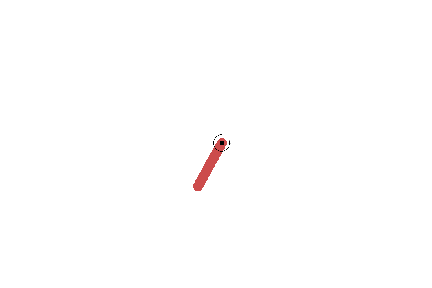
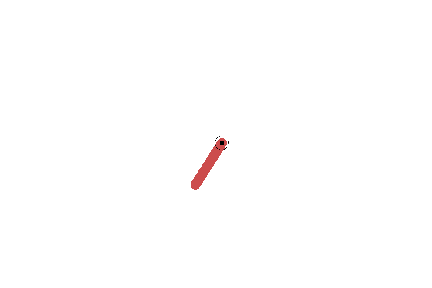
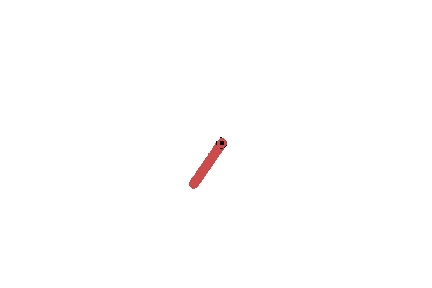
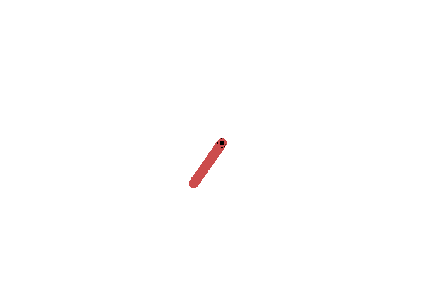
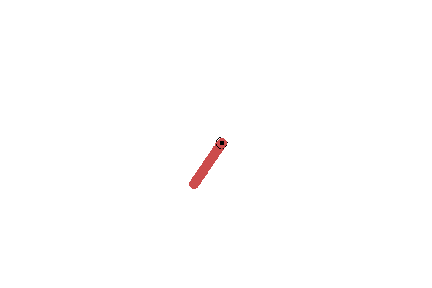
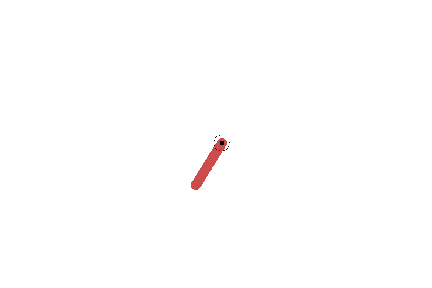
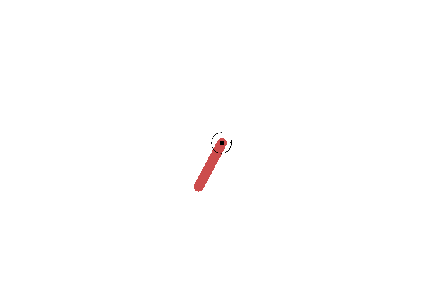
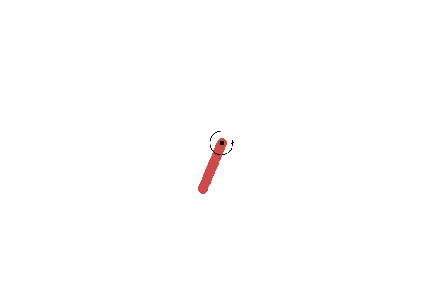
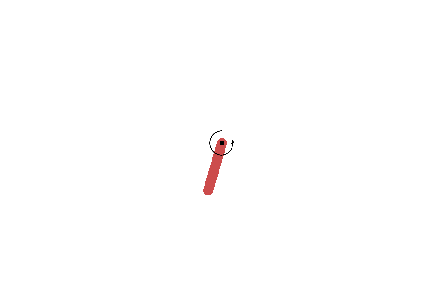
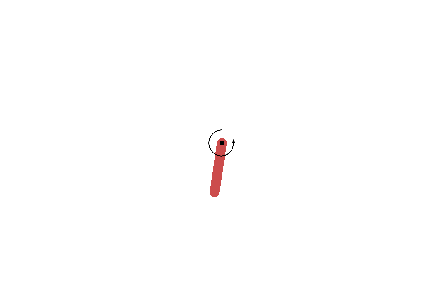
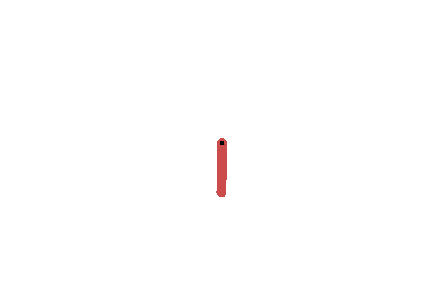
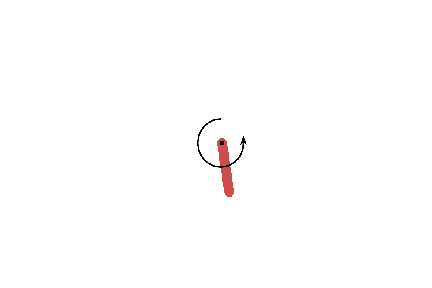
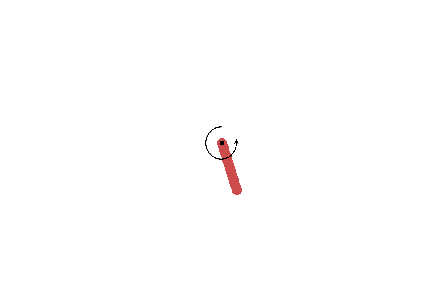
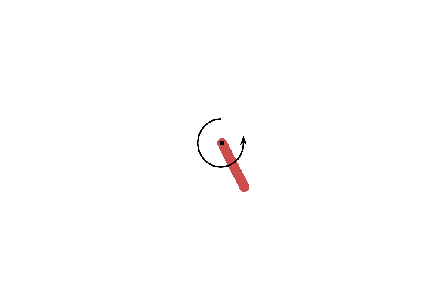
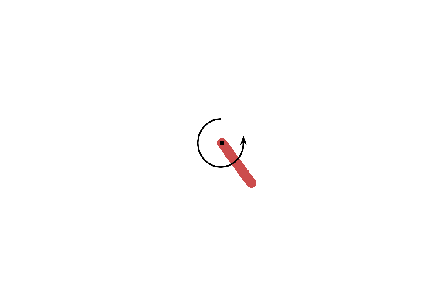
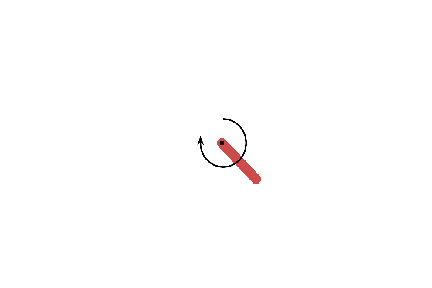
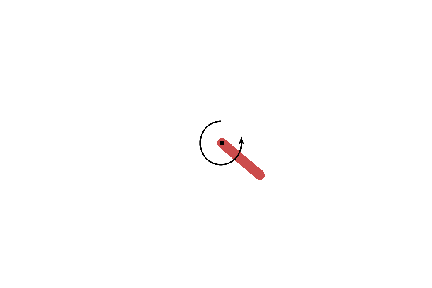
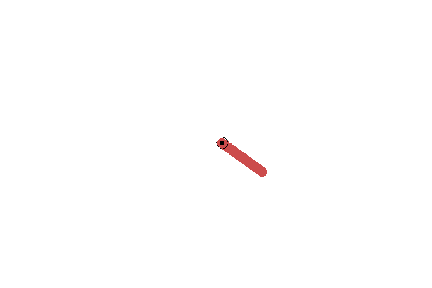
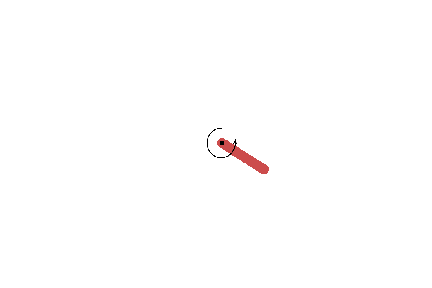
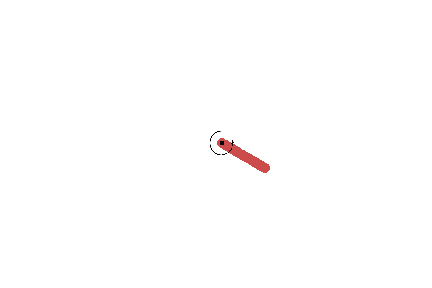
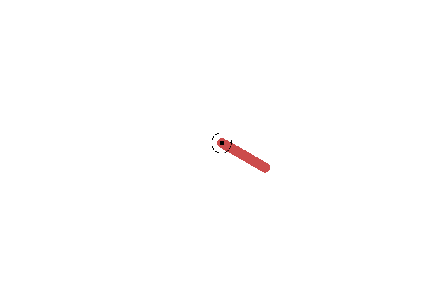
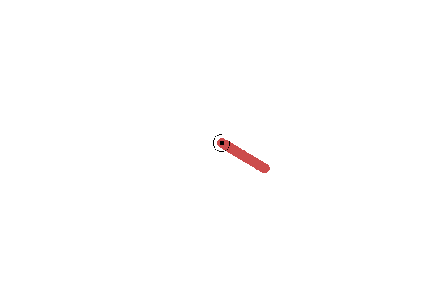
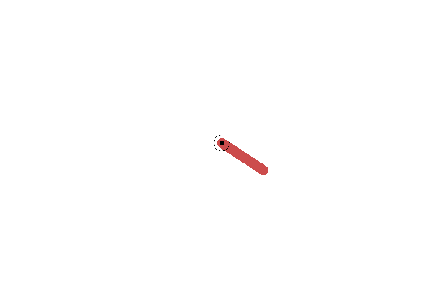
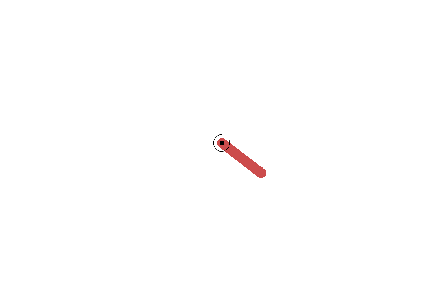
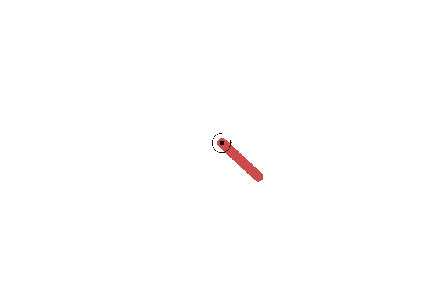
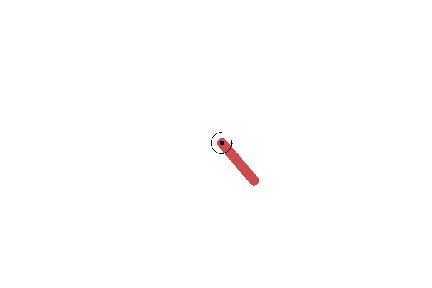
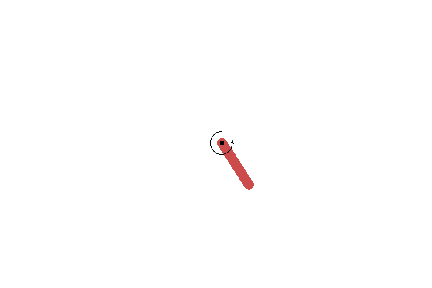
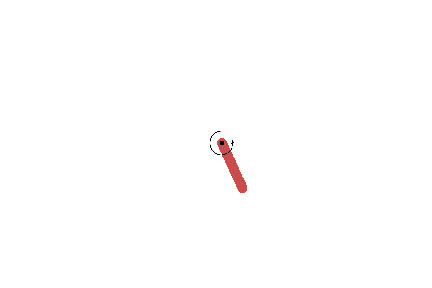
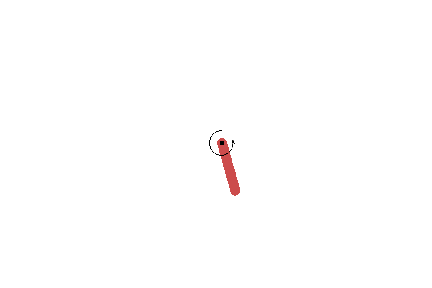
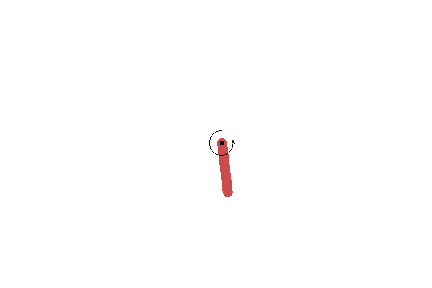
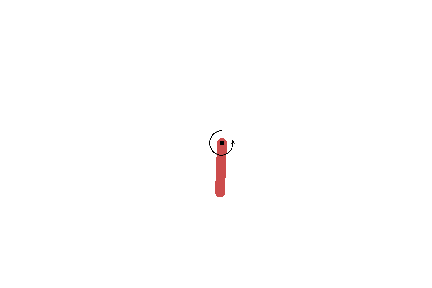
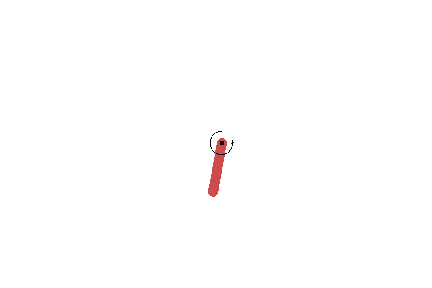
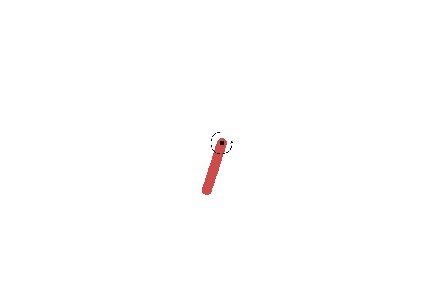
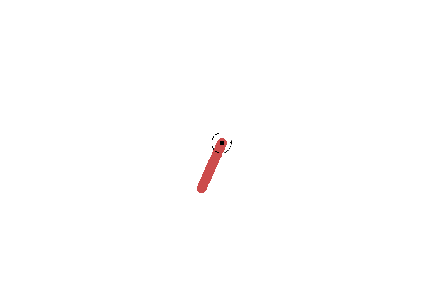
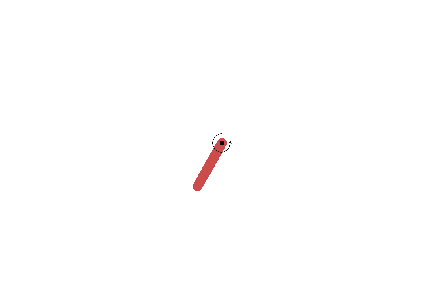
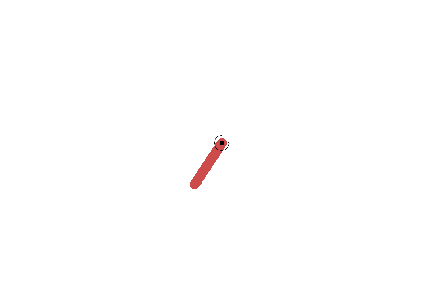
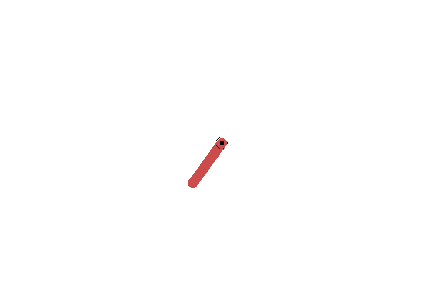
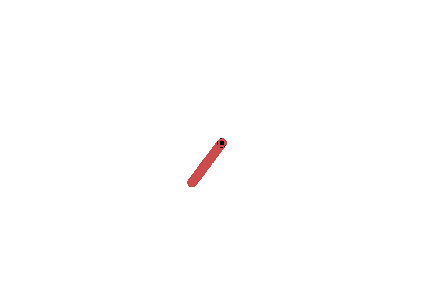
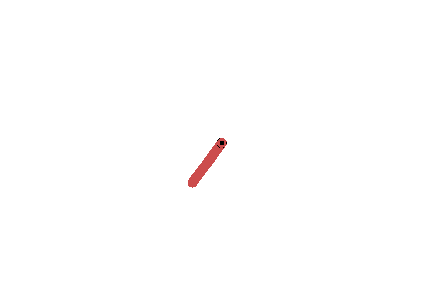
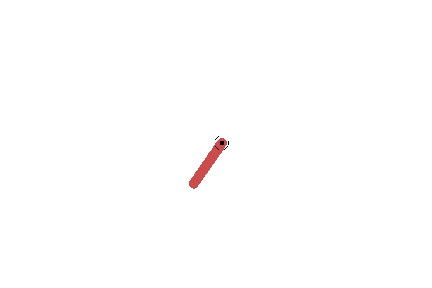
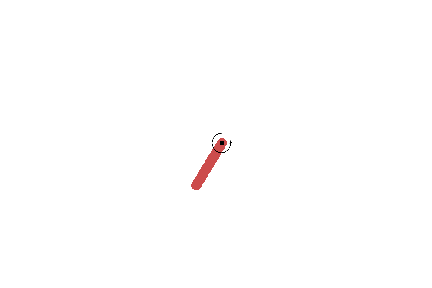
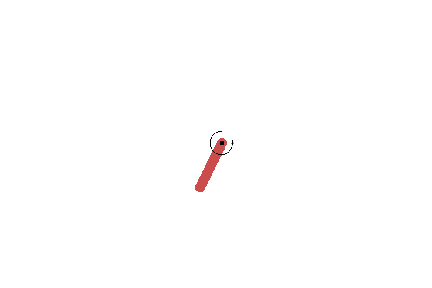
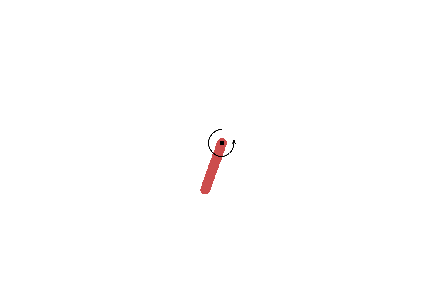
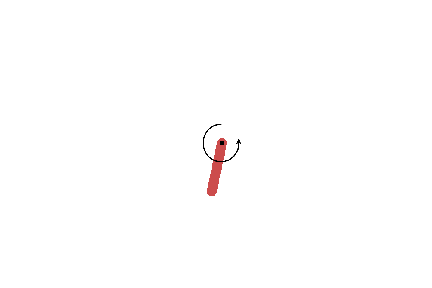
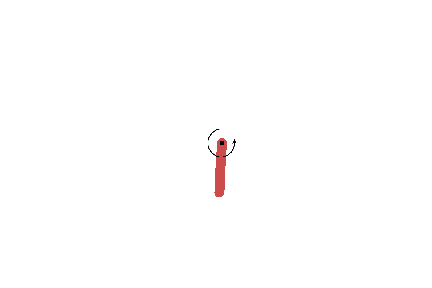
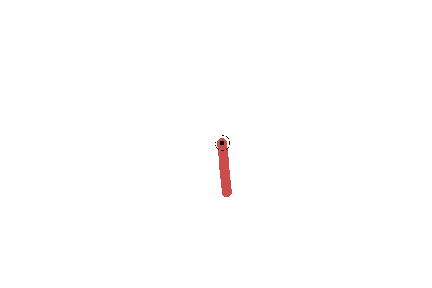
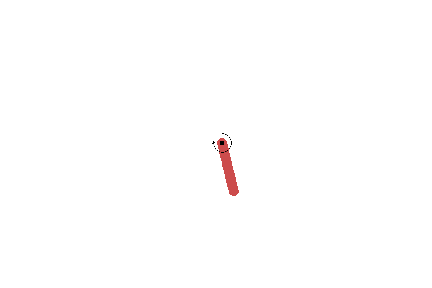
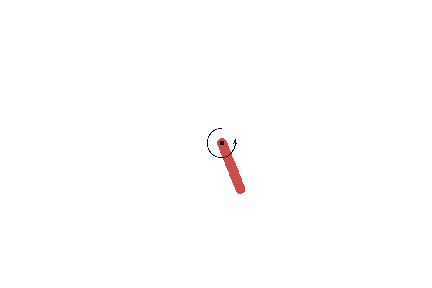
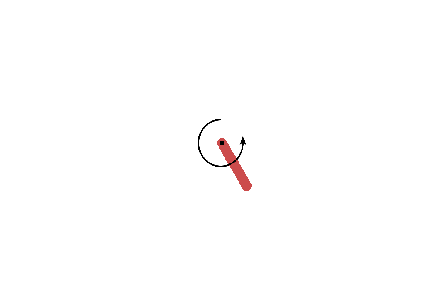
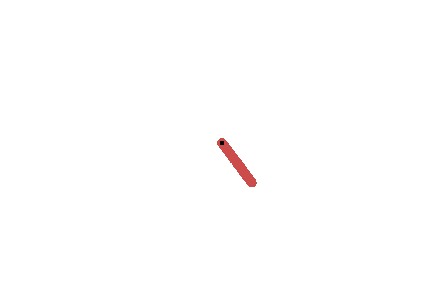
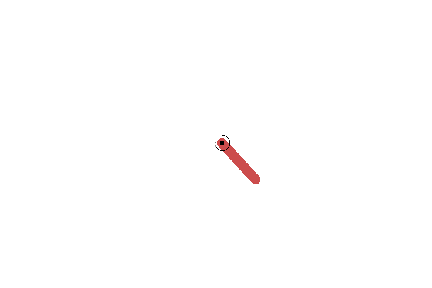
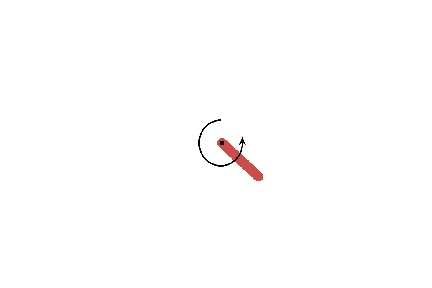
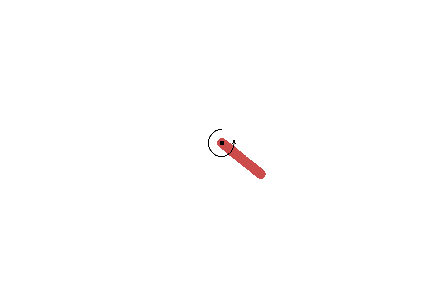
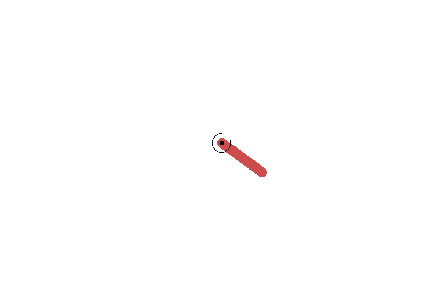
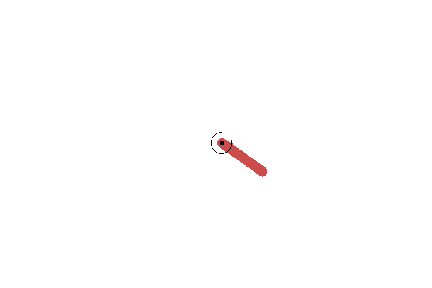
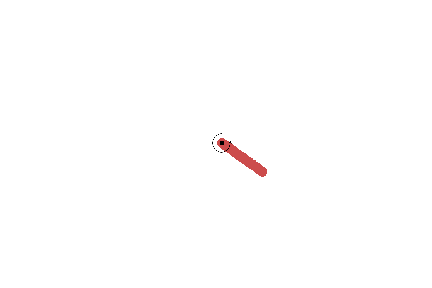
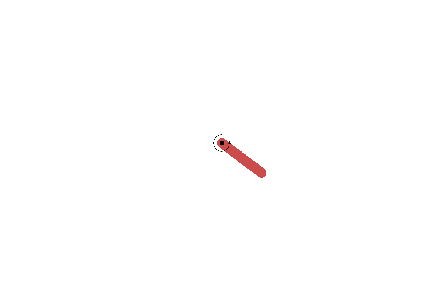
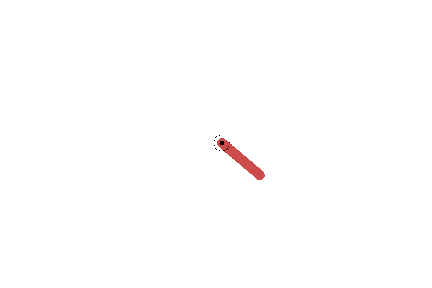
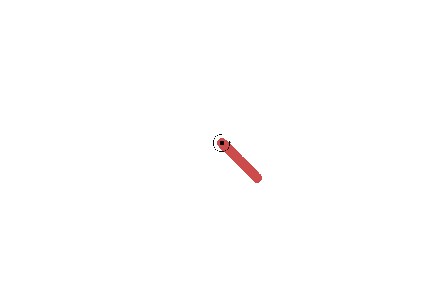
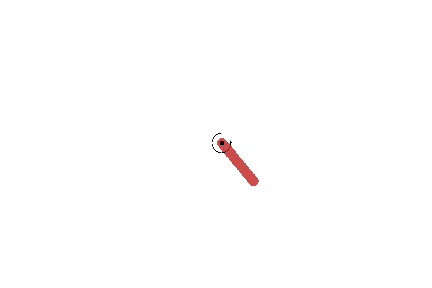
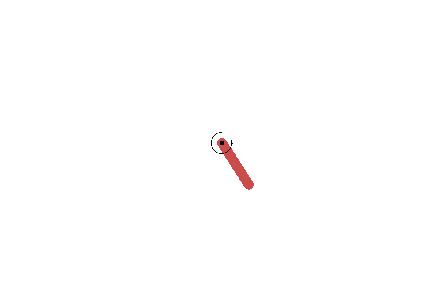
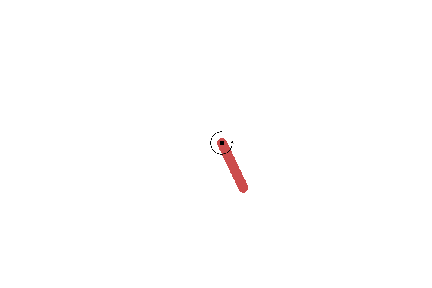
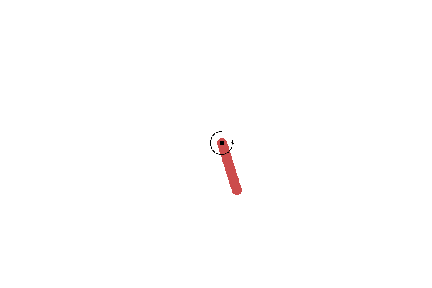
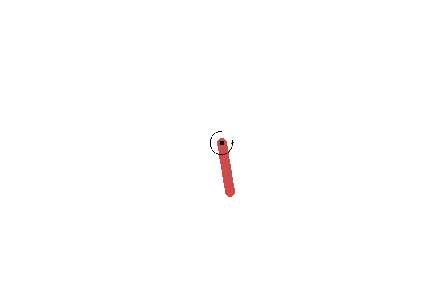
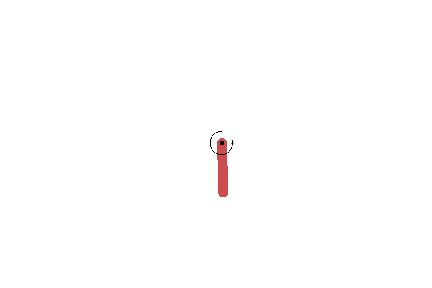
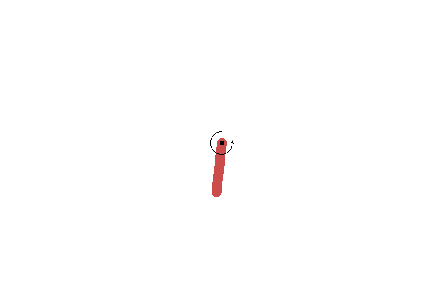
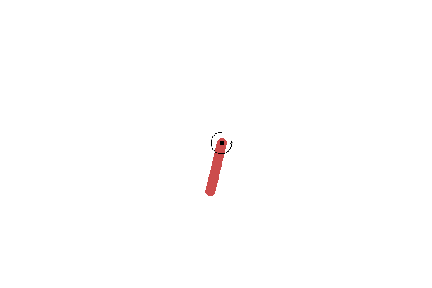
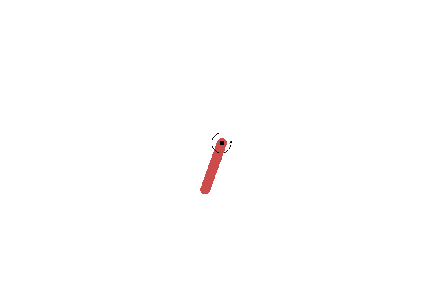
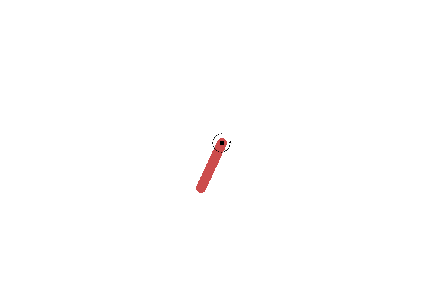
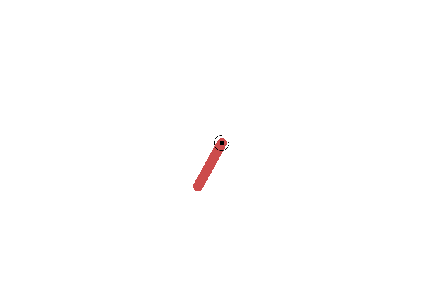
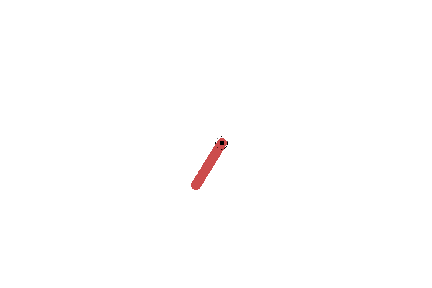
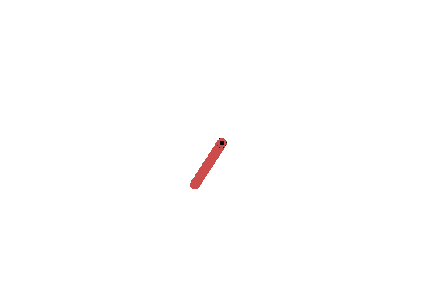
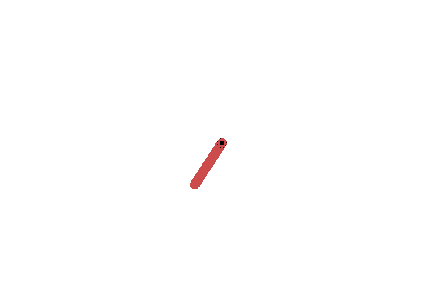
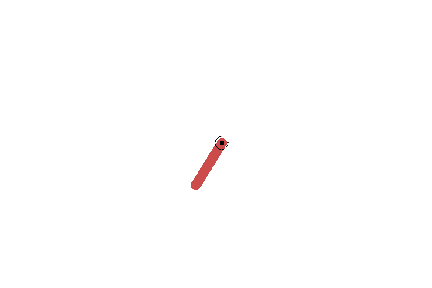
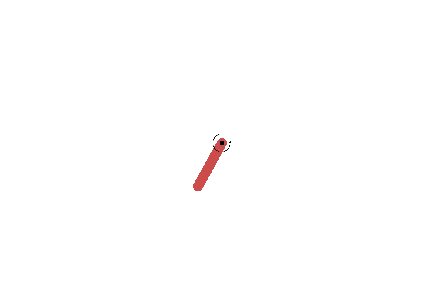
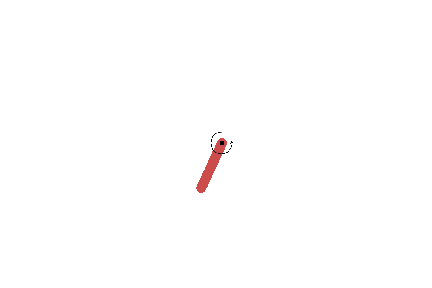
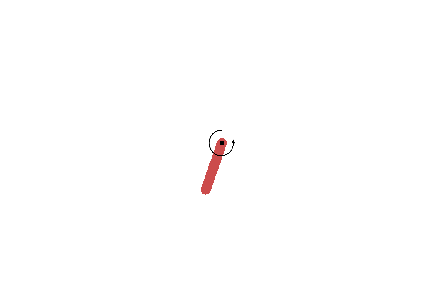
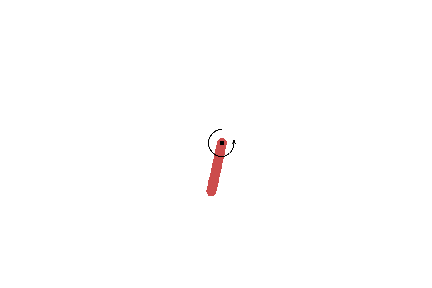
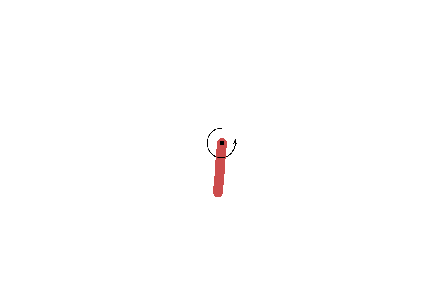
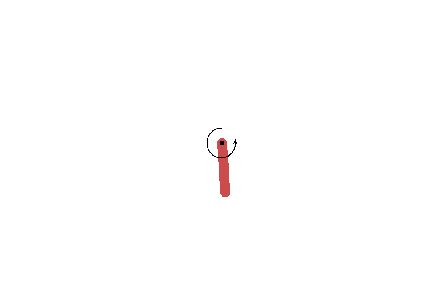
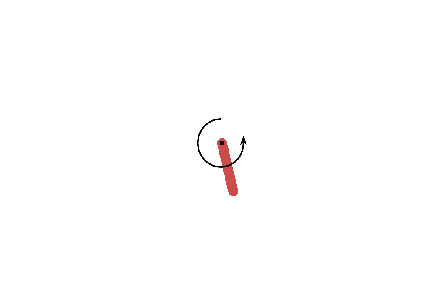
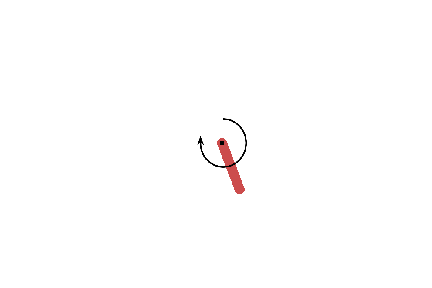
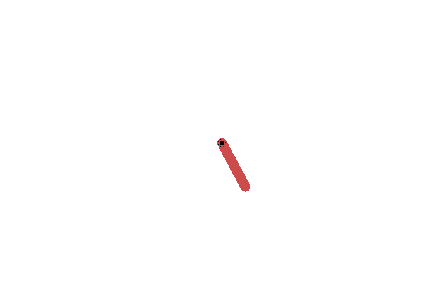
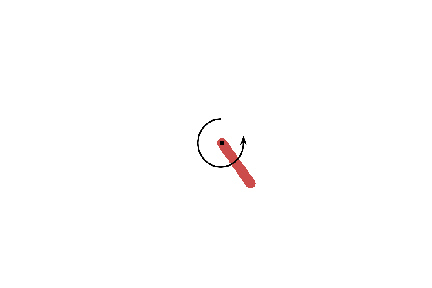
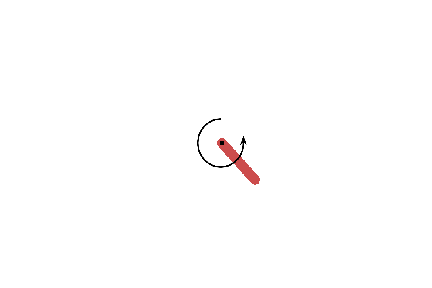
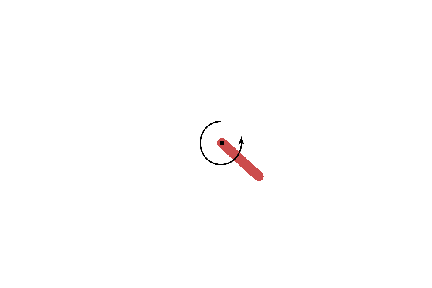
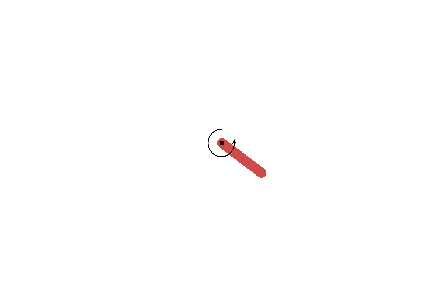
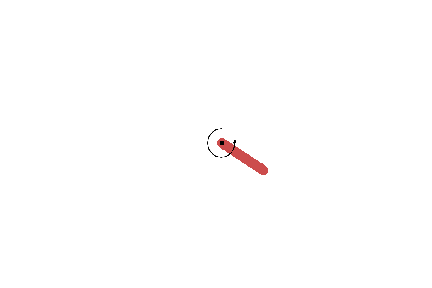
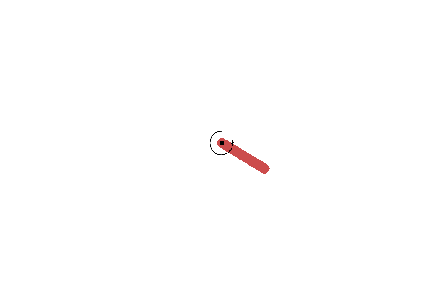
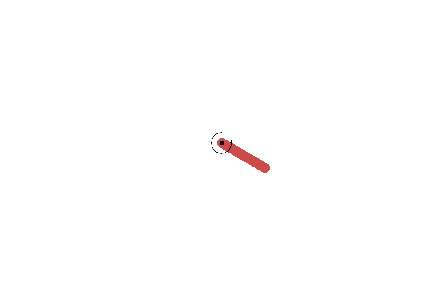
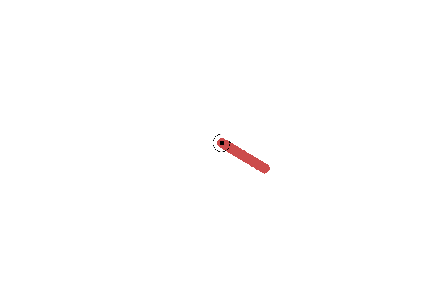
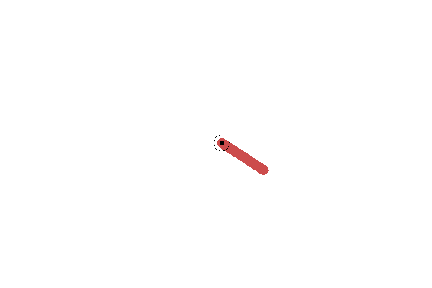
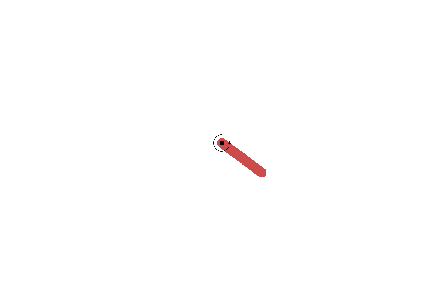
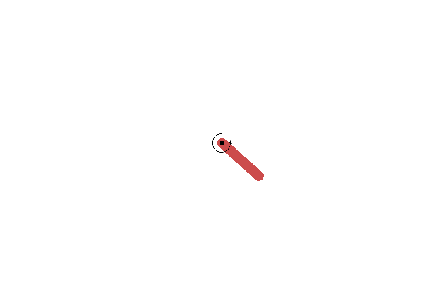
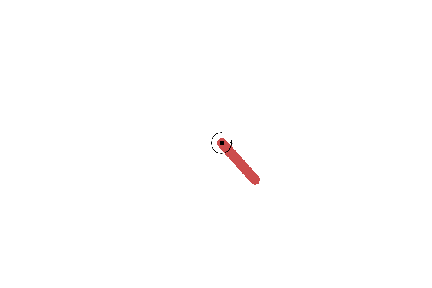
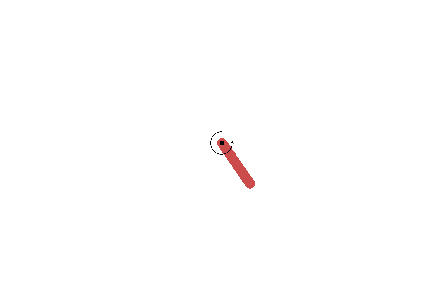
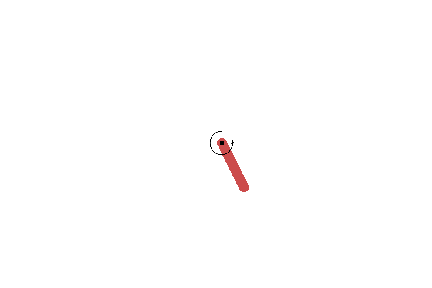

In [13]:
# Imports specifically so we can render outputs in Colab.
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display


def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    display(display_animation(anim, default_mode='loop'))
    
        
# display 
display_frames_as_gif(frames)